#<h1 align="center"><font color='BROWN'>BDA_PROJECT_PRESENTAION</font></h1>









#BATCHB_GROUP2


#GROUP_MEMEBRS:

#1.JAIDEV -CB.EN.U4AIE21117
#2.SAI CHANDANA.J -CB.EN.U4AIE21118
#3.PRANISH KUMAR . M - CB.EN.U4AIE21137
#4.CHARISHMA CHOWDARY . T - CB.EN.U4AIE21169

#DATA ANALYSIS USING LINEAR REGRESSION

importing the necessary librariers

In [41]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

Initialize a SparkSession

In [42]:
spark = SparkSession.builder.getOrCreate()

Load the data into a DataFrame

In [43]:
data = spark.read.format("csv").option("header", True).load("/content/africaeco.csv")


printing the number of rows & cols in data frame

In [44]:

row_count = data.count()
column_count = len(data.columns)

print("Number of rows:", row_count)
print("Number of columns:", column_count)


Number of rows: 2862
Number of columns: 12


printing the column names

In [45]:

columns = data.columns

print("Columns:", columns)


Columns: ['Country', 'Year', 'GDP_rise', 'Gini', 'Agg_dem', 'Agg_sup', 'Avg CPI', 'Eco_Equ', 'Per_cap', 'mar_cost', 'inf_rate', 'int_rate']


showing the data

In [48]:

data.show(20)


+-----------+----+--------+-----+-------+-------+-------+-------+-------+--------+--------+--------+
|    Country|Year|GDP_rise| Gini|Agg_dem|Agg_sup|Avg CPI|Eco_Equ|Per_cap|mar_cost|inf_rate|int_rate|
+-----------+----+--------+-----+-------+-------+-------+-------+-------+--------+--------+--------+
|    Nigeria|1950|       0|    0|   1.15|   8.55|   34.8| 258.66|      0|       0|       0|       0|
|   Ethiopia|1950|     2.1|15.61|   1.15|   8.55|   34.8| 258.66|    2.1|   15.61|     2.1|   15.61|
|      Egypt|1950|   0.468| 3.48|   1.15|   8.55|   34.8| 258.66|  0.468|    3.48|    0.66|    4.91|
|    DRcongo|1950| 0.15625| 1.16|   1.15|   8.55|   34.8| 258.66|0.15625|    1.16| 0.15625|    1.16|
|   Tanzania|1950|    1.65|12.26|   1.15|   8.55|   34.8| 258.66|   1.65|   12.26|    1.65|   12.26|
|SouthAfrica|1950|       1| 7.43|   1.15|   8.55|   34.8| 258.66|      1|    7.43|    1.25|    9.29|
|      Kenya|1950|     1.4|10.41|   1.15|   8.55|   34.8| 258.66|    1.4|   10.41|     1.4|

data frame dimenions

In [49]:

row_count = data.count()
column_count = len(data.columns)

print("Dimensions: {} rows by {} columns".format(row_count, column_count))


Dimensions: 2862 rows by 12 columns


Remove rows with null values

In [50]:
data = data.na.drop()

Convert the target column to float

In [51]:
target_column = "inf_rate"
data = data.withColumn(target_column, data[target_column].cast("float"))



1.   Convert columns to DoubleType
2.    Convert other feature columns as well



In [52]:
data = data.withColumn("GDP_rise", col("GDP_rise").cast("double"))
data = data.withColumn("Gini", col("Gini").cast("double"))

Continue with the VectorAssembler and linear regression code

In [53]:
assembler = VectorAssembler(inputCols=["GDP_rise", "Gini"], outputCol="features")
data = assembler.transform(data)


Select the features and target column automatically

In [54]:
data = data.select(col("features"), col(target_column))


Split the data into training and test sets

In [55]:
train_data, test_data = data.randomSplit([0.7, 0.3])

Convert the DataFrame to an RDD for further processing

In [56]:
train_rdd = train_data.rdd.map(lambda x: (DenseVector(x.features.toArray()), x[target_column]))

computing the gradient decent

In [57]:
def compute_gradient(features, target, weights):

    # Convert features to DenseVector
    features = DenseVector(features)

    # Compute the dot product of features and weights
    predictions = weights.dot(features)

    # Compute the error (predicted - actual)
    error = predictions - target

    # Compute the gradient using the formula: 2 * features * error
    gradient = 2 * features * error

    return gradient

importing the linear regression

In [58]:
from pyspark.ml.regression import LinearRegression

Train the linear regression model

In [59]:
lr = LinearRegression(featuresCol="features", labelCol=target_column)
model = lr.fit(train_data)

Make predictions on the test data

In [60]:
predictions = model.transform(test_data)

Evaluate the model's performance

In [61]:
from pyspark.ml.evaluation import RegressionEvaluator


In [62]:
evaluator = RegressionEvaluator(labelCol=target_column, metricName="rmse")
rmse = evaluator.evaluate(predictions)

#Print the root mean squared error

In [63]:
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.5295606002146657


#Print the model coefficients

In [64]:
coefficients = model.coefficients
print("Coefficients:", coefficients)


Coefficients: [1.012904661847599,-0.032792660725784364]


#Calculate the mean absolute error

In [65]:
evaluator_mae = RegressionEvaluator(labelCol=target_column, metricName="mae")
mae = evaluator_mae.evaluate(predictions)

# Print the mean absolute error
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.21800482992306291


#Scatter Plot of Actual vs. Predicted Values

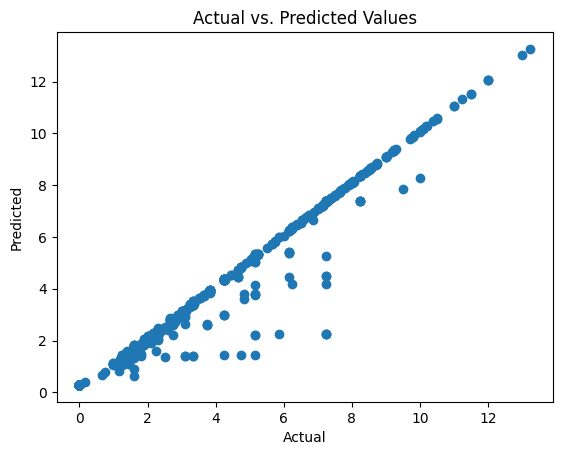

In [66]:

actual = predictions.select(target_column).rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.scatter(actual, predicted)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Values")
plt.show()


#Residual Plot

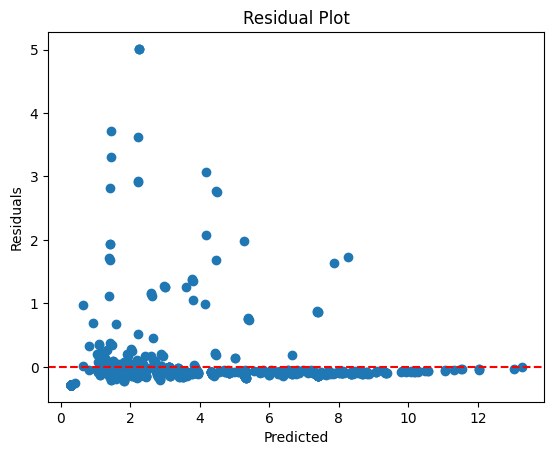

In [67]:

residuals = predictions.rdd.map(lambda x: x[target_column] - x["prediction"]).collect()

plt.scatter(predicted, residuals)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


#Feature Importance Plot

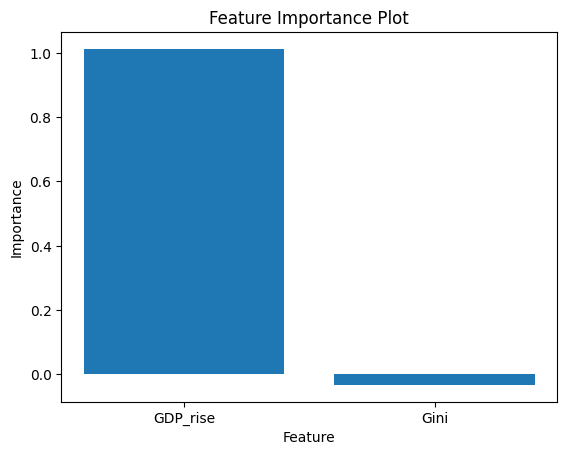

In [68]:

feature_names = ["GDP_rise", "Gini"]
importance_values = model.coefficients

plt.bar(feature_names, importance_values)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance Plot")
plt.show()


#<h1 align="center"><font color='BROWN'>THANK YOU </font></h1>